In [ ]:
import requests, zipfile, io
import cv2
import glob
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image
import os 
from dask import bag, diagnostics
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator 
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping
import keras
import tensorflow as tf
import random
from keras.utils import to_categorical
import albumentations as A
from google.colab import drive,files
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
# Set the seed for TensorFlow
tf.random.set_seed(1)
# Set the seed for NumPy
np.random.seed(1)
# Set the seed for the Python random module
random.seed(1)

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.mkdir('gdrive/MyDrive/data')
os.mkdir('gdrive/MyDrive/data/Resized-cocci')
os.mkdir('gdrive/MyDrive/data/Resized-healthy')
os.mkdir('gdrive/MyDrive/data/Resized-salmo')
os.mkdir('gdrive/MyDrive/data/Resized-ncd')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/healthy.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/salmo.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/ncd.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
r = requests.get("https://zenodo.org/record/4628934/files/cocci.zip")
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall('gdrive/MyDrive/data')

In [ ]:
def resize(folder,save_to):
  i= 0
  images = glob.glob(folder + "/*.jpg")
  for img in  images[:500]:
    image= Image.open(img)
    image= image.resize((299,299))
    image.save(f"{save_to}/resized{i}.jpg")
    i+=1
  print(f'successfully saved to {save_to}')

In [ ]:
resize('gdrive/MyDrive/data/salmo','gdrive/MyDrive/data/Resized-salmo')
resize('gdrive/MyDrive/data/healthy','gdrive/MyDrive/data/Resized-healthy')
resize('gdrive/MyDrive/data/cocci','gdrive/MyDrive/data/Resized-cocci')
resize('gdrive/MyDrive/data/ncd','gdrive/MyDrive/data/Resized-ncd')

successfully saved to gdrive/MyDrive/data/Resized-salmo-150
successfully saved to gdrive/MyDrive/data/Resized-healthy-150
successfully saved to gdrive/MyDrive/data/Resized-cocci-150


In [ ]:
# We will take only 500 images of each class 
cocci = glob.glob('gdrive/MyDrive/data/Resized-cocci/*.jpg')[:500]
healthy = glob.glob('gdrive/MyDrive/data/Resized-healthy/*.jpg')[:500]
salmo = glob.glob('gdrive/MyDrive/data/Resized-salmo/*.jpg')[:500]
ncd = glob.glob('gdrive/MyDrive/data/Resized-ncd/*.jpg')[:500]

In [ ]:
# we need to fix data imbalance (class NCD )
#Using Data Augmentation we can quickly increase the amount of data for our imbalanced classes,
#this will ensure that our model does not see the same image twice and helps avoid overfitting and aids the model to generalise better.
datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

In [ ]:
# we need to increase number of images in NCD class to be 500, which is the same as other classes 
# 376 + 124 = 500
#os.mkdir('ncd_over-sampling')
total = 0
for img in ncd:
  x = load_img(img) 
  x = img_to_array(x) # this is a Numpy array with shape (3, 150, 150)
  x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)
  for i in datagen.flow(x,save_to_dir="ncd_over-sampling",save_format="jpg"):
    break 
  if total == 124:
    break
  total = total + 1  

In [ ]:
x = load_img(ncd[0])
x = img_to_array(x)
x.shape

(299, 299, 3)

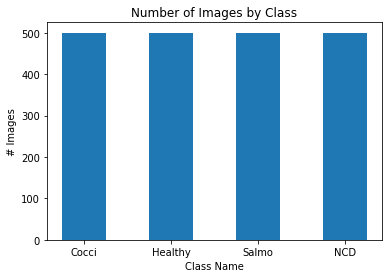

In [ ]:
dict_ = {"Cocci":len(cocci) ,
         "Healthy":len(healthy),
         "Salmo":len(salmo),
         "NCD":len(ncd)}
plt.bar(dict_.keys(), dict_.values(), width = .5)
plt.title("Number of Images by Class")
plt.xlabel('Class Name');
plt.ylabel('# Images');
plt.show()

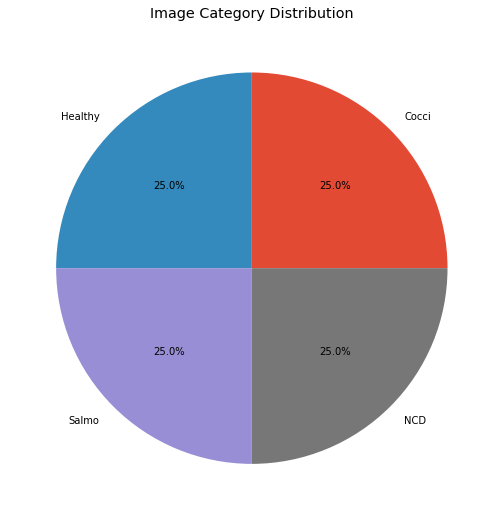

In [ ]:
labels = dict_.keys()
targets = dict_.values()
plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

In [ ]:
labels = []
data =[] 

In [ ]:
def prepare_images(array,class_no):
  for img in array:
    x = load_img(img)
    x = img_to_array(x)
    data.append(x)
    labels.append(class_no)

In [ ]:
prepare_images(cocci,0)
prepare_images(healthy,1)
prepare_images(salmo,2)
prepare_images(ncd,3)

In [ ]:
data = np.array(data)
labels = to_categorical(labels)

In [ ]:
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2, random_state=1,shuffle=True)

In [ ]:
base_model = InceptionV3(input_shape = (299, 299, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 6s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
# Add a classification head
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(4, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 4)                 260       
                                                                 
Total params: 21,934,180
Trainable params: 131,396
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_tl.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-3),  metrics=['accuracy'])

In [ ]:
history = model.fit(
    X_train,ytrain, epochs = 100 , batch_size=12,validation_data=(X_test, ytest),callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
134/134 [==============================] - 25s 95ms/step - loss: 5.8246 - accuracy: 0.4787 - val_loss: 2.7165 - val_accuracy: 0.4525
Epoch 2/100
134/134 [==============================] - 10s 73ms/step - loss: 2.7496 - accuracy: 0.5531 - val_loss: 1.8567 - val_accuracy: 0.6175
Epoch 3/100
134/134 [==============================] - 9s 68ms/step - loss: 1.8597 - accuracy: 0.6194 - val_loss: 2.1004 - val_accuracy: 0.5425
Epoch 4/100
134/134 [==============================] - 11s 80ms/step - loss: 1.7978 - accuracy: 0.6037 - val_loss: 1.9430 - val_accuracy: 0.6300
Epoch 5/100
134/134 [==============================] - 9s 71ms/step - loss: 1.3924 - accuracy: 0.6244 - val_loss: 1.5289 - val_accuracy: 0.5925
Epoch 6/100
134/134 [==============================] - 10s 71ms/step - loss: 1.1090 - accuracy: 0.6687 - val_loss: 1.1448 - val_accuracy: 0.6175
Epoch 7/100
134/134 [==============================] - 9s 70ms/step - loss: 1.1944 - accuracy: 0.6825 - val_loss: 3.2984 - val_accur

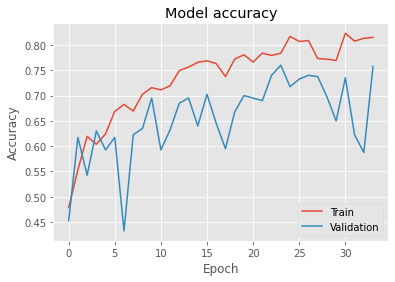

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
best_model_tl = keras.models.load_model('best_model_tl.h5')

In [ ]:
# Get predictions
y_pred = best_model_tl.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)

13/13 [==============================] - 6s 222ms/step

--- Confusion Matrix ---

[[78  5  6  6]
 [ 3 86  5  6]
 [ 5  4 85  8]
 [12 14 22 55]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       0.80      0.82      0.81        95
           1       0.79      0.86      0.82       100
           2       0.72      0.83      0.77       102
           3       0.73      0.53      0.62       103

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.75       400



In [ ]:
# Unfreeze some layers in the base model
base_model.trainable = True
# free some memory 
del best_model_tl
del data 
del labels 

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=1e-4),  metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
model_checkpoint = keras.callbacks.ModelCheckpoint(filepath='best_model_fn.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
history = model.fit(
    X_train,ytrain, epochs = 100 , batch_size=32,validation_data=(X_test, ytest),callbacks=[early_stopping,model_checkpoint])

Epoch 1/100
50/50 [==============================] - 40s 556ms/step - loss: 0.5191 - accuracy: 0.8256 - val_loss: 1.6819 - val_accuracy: 0.3575
Epoch 2/100
50/50 [==============================] - 26s 515ms/step - loss: 0.1140 - accuracy: 0.9663 - val_loss: 0.4511 - val_accuracy: 0.8625
Epoch 3/100
50/50 [==============================] - 25s 506ms/step - loss: 0.0594 - accuracy: 0.9850 - val_loss: 0.1689 - val_accuracy: 0.9450
Epoch 4/100
50/50 [==============================] - 25s 511ms/step - loss: 0.0284 - accuracy: 0.9919 - val_loss: 0.1985 - val_accuracy: 0.9500
Epoch 5/100
50/50 [==============================] - 24s 484ms/step - loss: 0.0227 - accuracy: 0.9962 - val_loss: 0.2253 - val_accuracy: 0.9450
Epoch 6/100
50/50 [==============================] - 24s 479ms/step - loss: 0.0090 - accuracy: 0.9987 - val_loss: 0.2185 - val_accuracy: 0.9425
Epoch 7/100
50/50 [==============================] - 24s 481ms/step - loss: 0.0128 - accuracy: 0.9950 - val_loss: 0.2445 - val_accuracy:

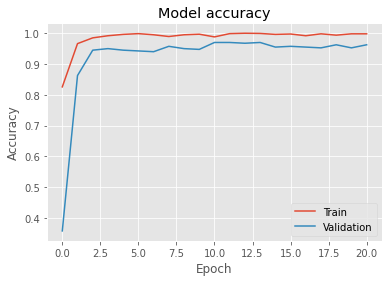

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# load the best model
best_model_fn = keras.models.load_model('best_model_fn.h5')

In [ ]:
# Get predictions
y_pred = best_model_fn.predict(X_test)

# Convert predictions to class labels
y_pred_class = np.argmax(y_pred, axis=1)

# Convert true labels to class labels
y_true_class = np.argmax(ytest, axis=1)

# Get confusion matrix
confusion_mat = confusion_matrix(y_true_class, y_pred_class)
print("\n--- Confusion Matrix ---\n")
print(confusion_mat)
# Get classification report
classification = classification_report(y_true_class, y_pred_class)
print("\n\n\t\t--- Classification Report ---\n")
print(classification)

13/13 [==============================] - 3s 121ms/step

--- Confusion Matrix ---

[[ 95   0   0   0]
 [  0  92   4   4]
 [  1   1 100   0]
 [  0   1   1 101]]


		--- Classification Report ---

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        95
           1       0.98      0.92      0.95       100
           2       0.95      0.98      0.97       102
           3       0.96      0.98      0.97       103

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400

